# Essais de segmentation améliorés

Ce notebook présente une analyse de segmentation améliorée des clients, incluant la normalisation des données, le clustering K-means, l'analyse DBSCAN, et l'analyse RFM.

In [14]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import warnings

# Ignorer les avertissements pour une meilleure lisibilité
warnings.filterwarnings("ignore")

# Configuration de l'affichage des graphiques
plt.style.use('ggplot')
sns.set_palette("viridis")

## 1. Chargement et préparation des données

In [15]:
# Chargement des données
df = pd.read_csv('data/clean.csv')
print(df.info())

# Affichage d'un échantillon des données
print(df.sample(10))

# Statistiques descriptives
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94269 entries, 0 to 94268
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         94269 non-null  object 
 1   total_orders               94269 non-null  int64  
 2   avg_delivery_time_days     94269 non-null  float64
 3   days_since_last_order      94269 non-null  float64
 4   total_spent                94269 non-null  float64
 5   avg_review_score           94269 non-null  float64
 6   max_delivery_delay_days    94269 non-null  float64
 7   has_comment                94269 non-null  int64  
 8   last_payment_type          94269 non-null  object 
 9   last_payment_installments  94269 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 7.2+ MB
None
                     customer_unique_id  total_orders  avg_delivery_time_days  \
18061  30e9a737d78837aa7ec75a9332964964             1               18.

## 2. Normalisation des données

In [16]:
# Initialisation du MinMaxScaler
scaler = MinMaxScaler()

# Liste des colonnes à normaliser
columns_to_normalize = [
    'total_orders', 'avg_delivery_time_days', 'days_since_last_order',
    'total_spent', 'avg_review_score', 'max_delivery_delay_days', 'has_comment', 'last_payment_installments'
]

# Normalisation des colonnes
for col in columns_to_normalize:
    df[f'{col}_normalized'] = scaler.fit_transform(df[[col]])

# Affichage des données normalisées
print(df[['total_orders', 'total_orders_normalized']].head())

   total_orders  total_orders_normalized
0             1                      0.0
1             1                      0.0
2             1                      0.0
3             1                      0.0
4             1                      0.0


## 3. Visualisation des données normalisées

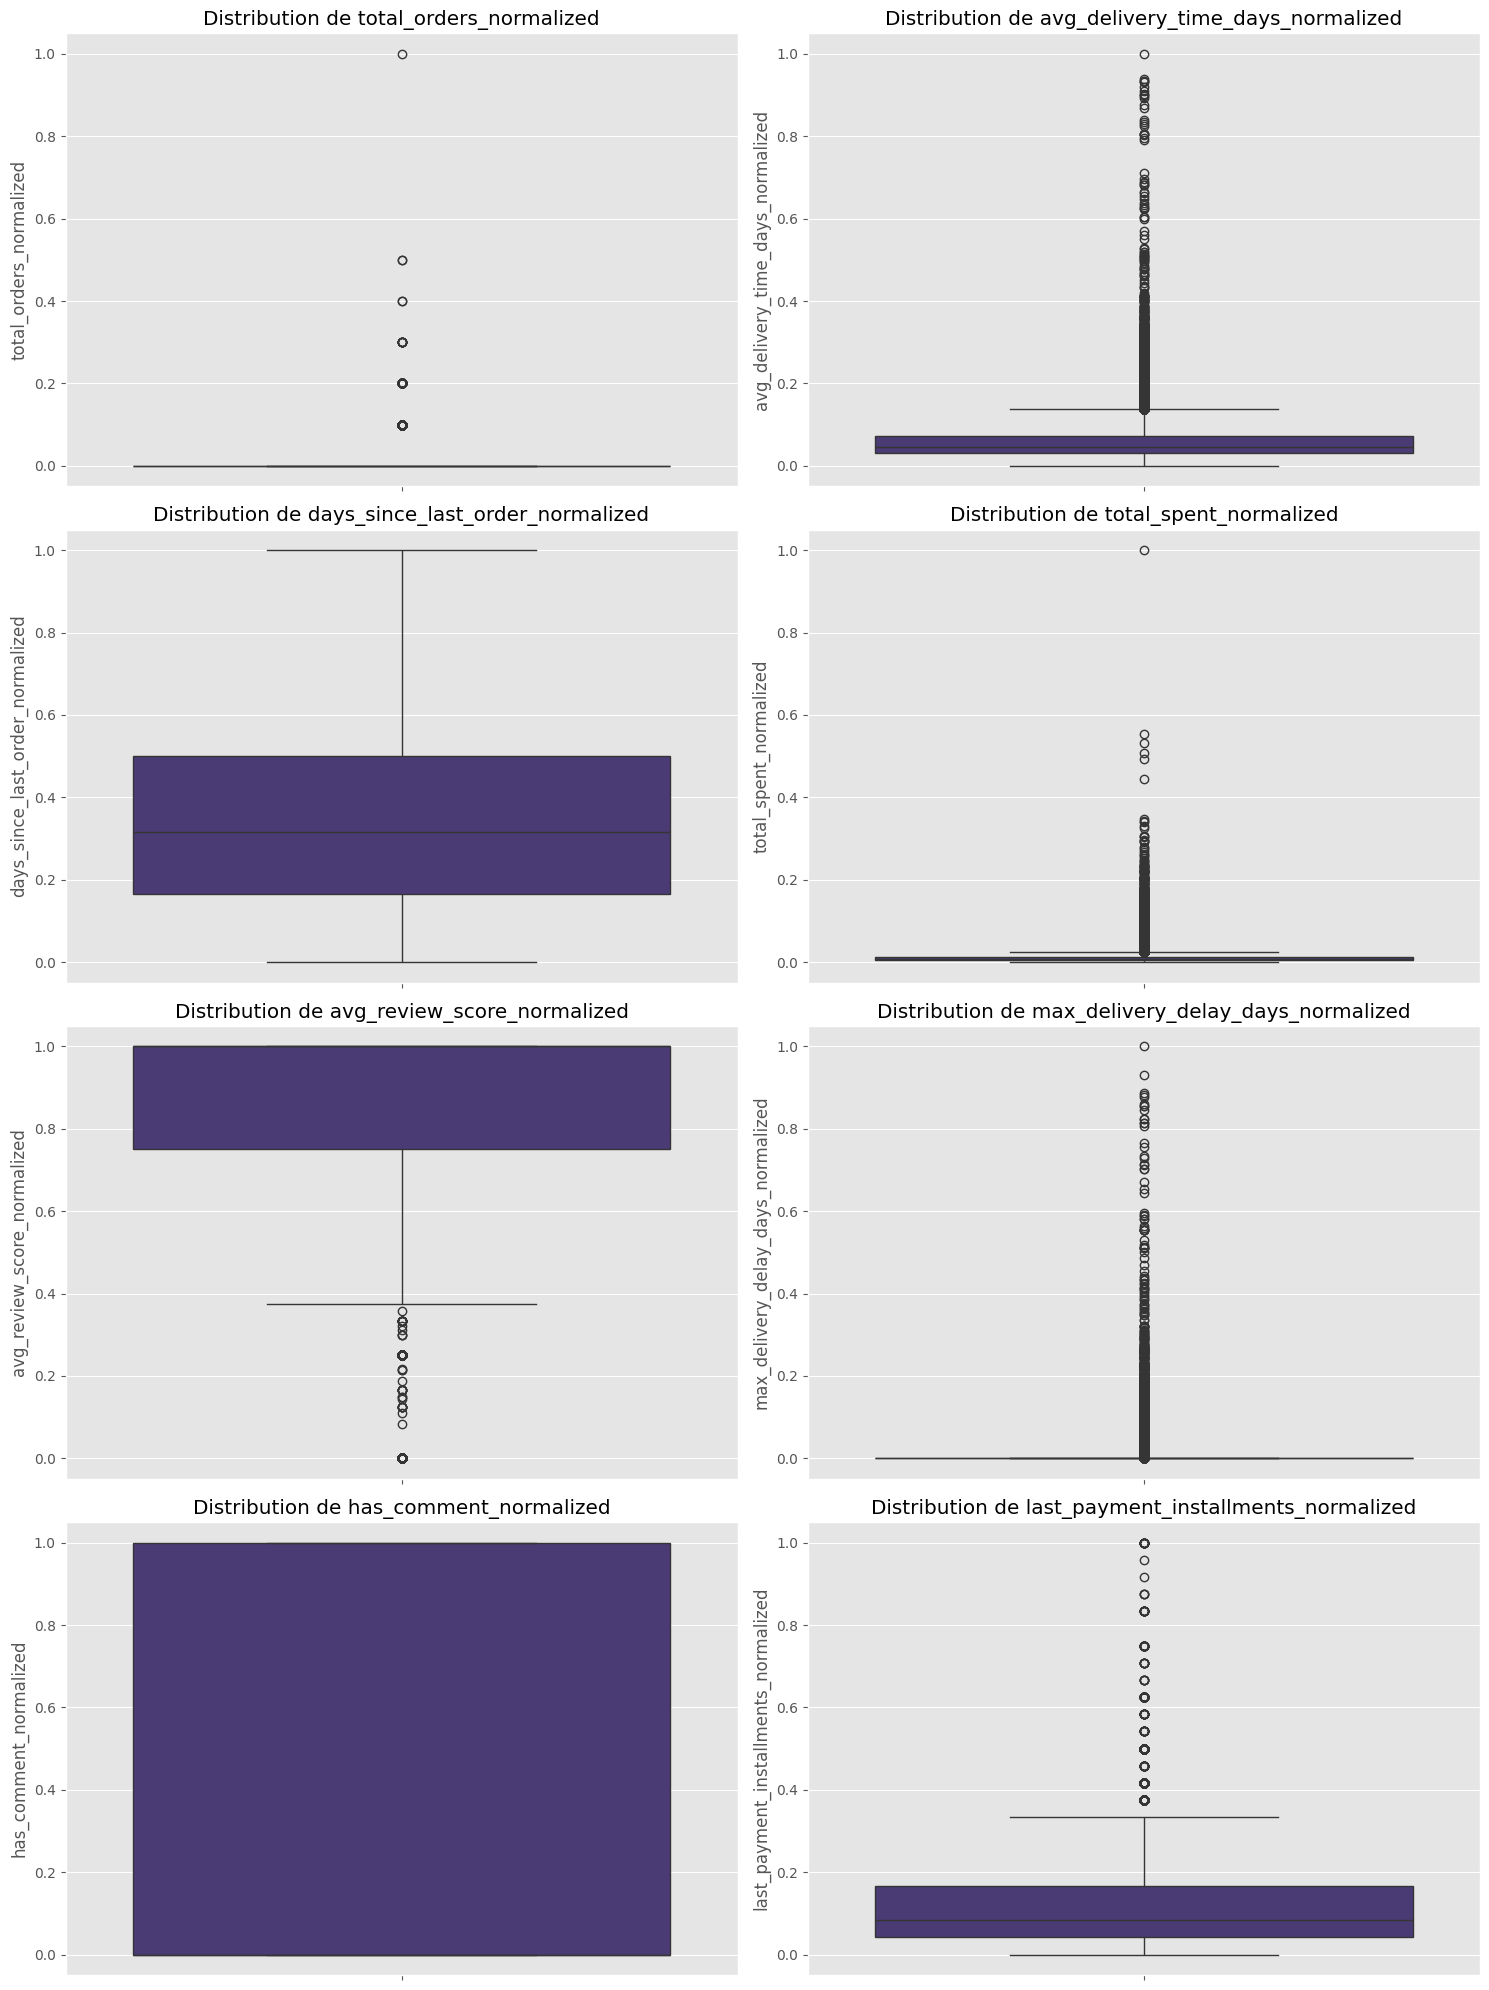

In [17]:
# Fonction pour créer des box plots
def plot_boxplots(data, columns, n_cols=2):
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.boxplot(data=data, y=col, ax=axes[i])
        axes[i].set_title(f'Distribution de {col}')

    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Création des box plots pour les colonnes normalisées
normalized_columns = [f'{col}_normalized' for col in columns_to_normalize]
plot_boxplots(df, normalized_columns)

## 4. Clustering K-means

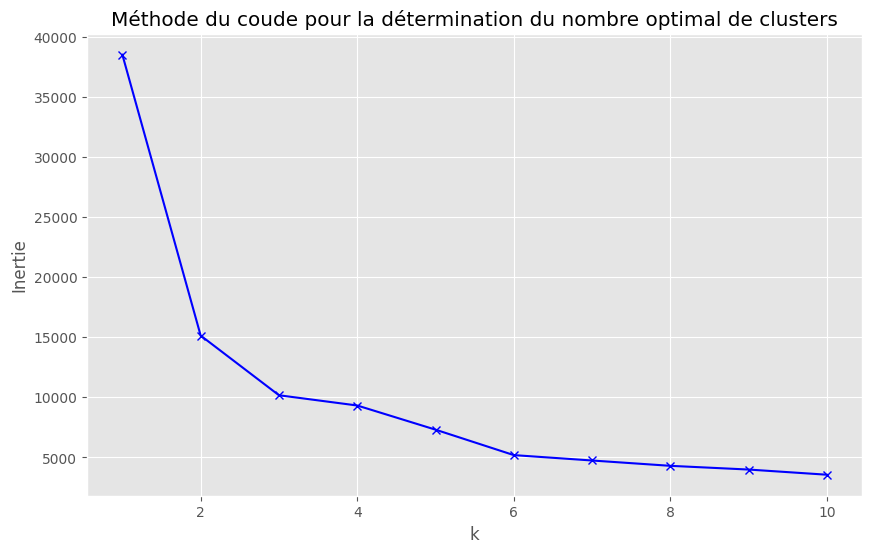

               total_orders_normalized  avg_delivery_time_days_normalized  \
cluster_label                                                               
0                             0.001419                           0.053566   
1                             0.001840                           0.055512   
2                             0.001678                           0.091706   
3                             0.002305                           0.051493   
4                             0.001499                           0.048039   
5                             0.001322                           0.081242   

               days_since_last_order_normalized  total_spent_normalized  \
cluster_label                                                             
0                                      0.551678                0.010739   
1                                      0.573142                0.011674   
2                                      0.340409                0.013970   
3       

In [18]:
# Sélection des features pour le clustering
features = df[normalized_columns]

# Méthode du coude pour trouver le nombre optimal de clusters
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertias.append(kmeans.inertia_)

# Visualisation de la courbe du coude
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour la détermination du nombre optimal de clusters')
plt.show()

# Choix du nombre optimal de clusters (à ajuster selon le graphique)
optimal_k = 6

# Application de K-means avec le nombre optimal de clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster_label'] = kmeans_optimal.fit_predict(features)

# Affichage des résultats
print(df[['cluster_label'] + normalized_columns].groupby('cluster_label').mean())

## 5. Visualisation des clusters K-means

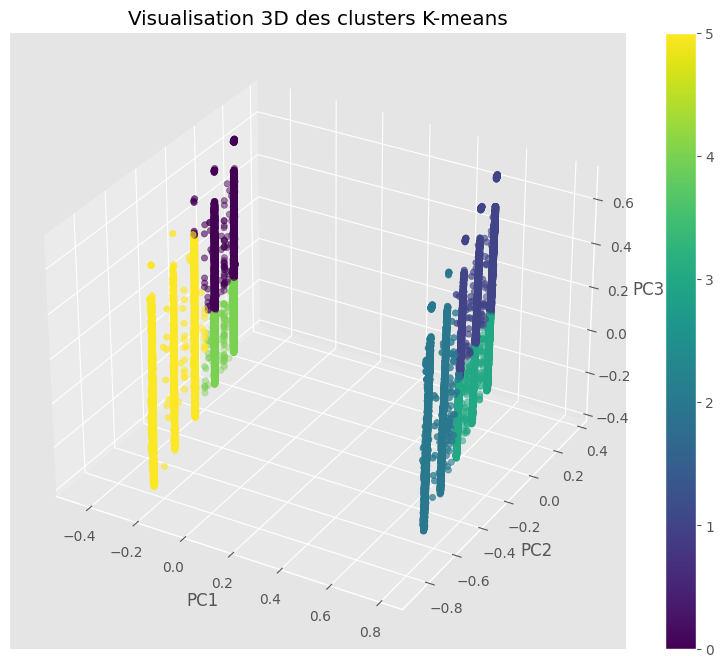

Variance expliquée par chaque composante principale:
PC1: 61.63%
PC2: 22.74%
PC3: 11.83%
Variance totale expliquée: 96.20%


In [19]:
# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)

# Ajout des composantes principales au DataFrame
df['pca1'], df['pca2'], df['pca3'] = pca_result[:, 0], pca_result[:, 1], pca_result[:, 2]

# Visualisation 3D des clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['pca1'], df['pca2'], df['pca3'], c=df['cluster_label'], cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Visualisation 3D des clusters K-means')
plt.colorbar(scatter)
plt.show()

# Affichage de la variance expliquée par chaque composante
print("Variance expliquée par chaque composante principale:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.2%}")
print(f"Variance totale expliquée: {sum(pca.explained_variance_ratio_):.2%}")

## 6. Analyse DBSCAN

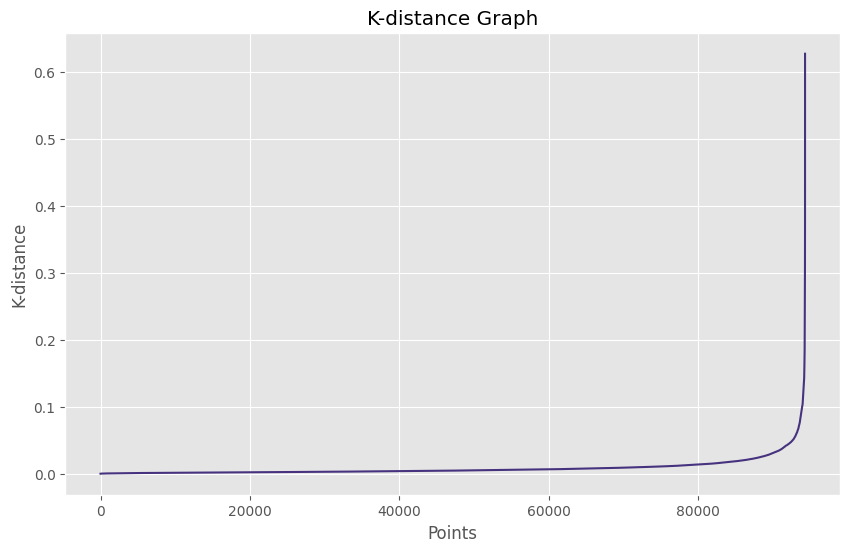

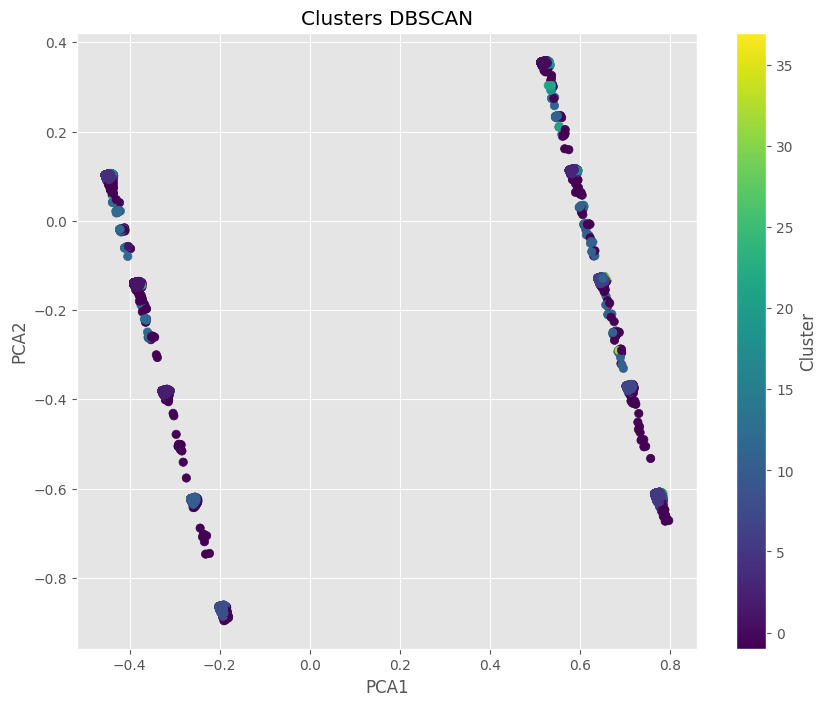

Nombre estimé de clusters: 39
Nombre estimé de points de bruit: 683


In [20]:
# Détermination de l'epsilon optimal
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(features)
distances, _ = neighbors_fit.kneighbors(features)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Points')
plt.ylabel('K-distance')
plt.show()

# Choix de l'epsilon (à ajuster selon le graphique)
epsilon = 0.1

# Application de DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(features)

# Visualisation des résultats DBSCAN
plt.figure(figsize=(10, 8))
plt.scatter(df['pca1'], df['pca2'], c=df['dbscan_cluster'], cmap='viridis')
plt.title('Clusters DBSCAN')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()

# Analyse des résultats
n_clusters = len(set(df['dbscan_cluster'])) - (1 if -1 in df['dbscan_cluster'] else 0)
n_noise = list(df['dbscan_cluster']).count(-1)
print(f'Nombre estimé de clusters: {n_clusters}')
print(f'Nombre estimé de points de bruit: {n_noise}')

## 7. Analyse RFM (Recency, Frequency, Monetary)

          Recency  Frequency  Monetary  R_score  F_score  M_score RFM_Score
78275  168.601933          1    104.56        4        1        3       413
64812  272.297697          1     93.30        3        1        3       313
36908   64.070405          1     30.13        5        1        1       511
10377  386.748634          1    148.58        2        1        4       214
14835  238.112917          1     97.72        3        1        3       313
69011  309.067870          1    116.94        3        1        3       313
31090  248.427905          1     33.79        3        1        1       311
83031   56.119537          1     94.83        5        1        3       513
22991  264.119433          1     83.96        3        1        2       312
25210  245.130104          2     49.68        3        5        1       351


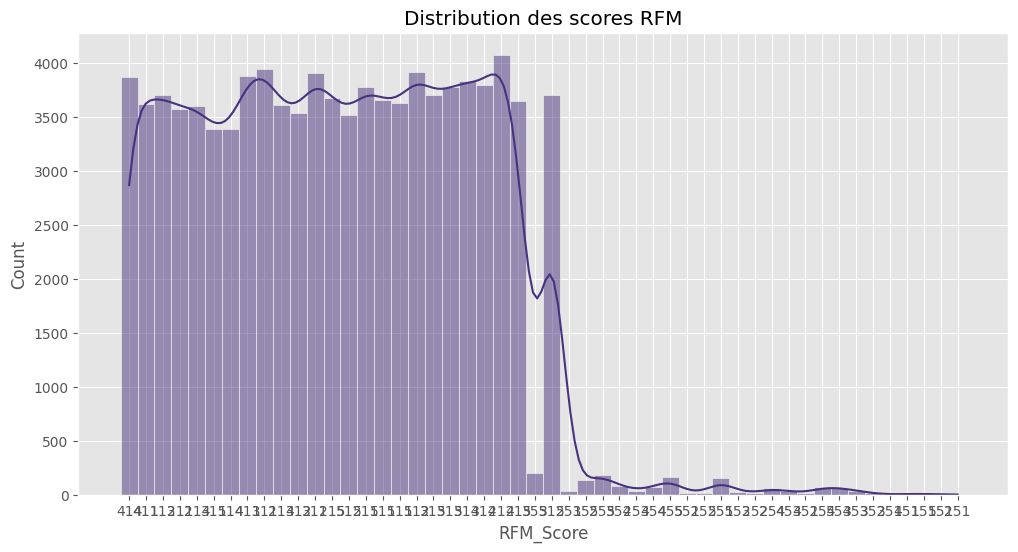

In [21]:
# Préparation des données RFM
df['Recency'] = df['days_since_last_order']
df['Frequency'] = df['total_orders']
df['Monetary'] = df['total_spent']

# Fonction pour attribuer les scores RFM
def assign_rfm_score(value, percentiles, high_is_good=True):
    if high_is_good:
        if value <= percentiles[0]:
            return 1
        elif value <= percentiles[1]:
            return 2
        elif value <= percentiles[2]:
            return 3
        elif value <= percentiles[3]:
            return 4
        else:
            return 5
    else:
        if value <= percentiles[0]:
            return 5
        elif value <= percentiles[1]:
            return 4
        elif value <= percentiles[2]:
            return 3
        elif value <= percentiles[3]:
            return 2
        else:
            return 1

# Calcul des percentiles
percentiles = {
    'Recency': df['Recency'].quantile([0.2, 0.4, 0.6, 0.8]).values,
    'Frequency': df['Frequency'].quantile([0.2, 0.4, 0.6, 0.8]).values,
    'Monetary': df['Monetary'].quantile([0.2, 0.4, 0.6, 0.8]).values
}

# Attribution des scores RFM
df['R_score'] = df['Recency'].apply(lambda x: assign_rfm_score(x, percentiles['Recency'], False))
df['F_score'] = df['Frequency'].apply(lambda x: assign_rfm_score(x, percentiles['Frequency']))
df['M_score'] = df['Monetary'].apply(lambda x: assign_rfm_score(x, percentiles['Monetary']))

# Calcul du score RFM global
df['RFM_Score'] = df['R_score'].astype(str) + df['F_score'].astype(str) + df['M_score'].astype(str)

# Affichage des résultats RFM
print(df[['Recency', 'Frequency', 'Monetary', 'R_score', 'F_score', 'M_score', 'RFM_Score']].sample(10))

# Visualisation de la distribution des scores RFM
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='RFM_Score', kde=True)
plt.title('Distribution des scores RFM')
plt.show()

## 8. Comparaison des résultats

In [22]:
# Fonction pour créer un tableau croisé
def create_crosstab(df, col1, col2):
    ct = pd.crosstab(df[col1], df[col2])
    return ct.style.background_gradient(cmap='YlOrRd')

# Comparaison K-means vs DBSCAN
print("Comparaison K-means vs DBSCAN:")
display(create_crosstab(df, 'cluster_label', 'dbscan_cluster'))

# Comparaison K-means vs RFM
print("\nComparaison K-means vs RFM:")
display(create_crosstab(df, 'cluster_label', 'RFM_Score'))

# Comparaison DBSCAN vs RFM
print("\nComparaison DBSCAN vs RFM:")
display(create_crosstab(df, 'dbscan_cluster', 'RFM_Score'))

Comparaison K-means vs DBSCAN:


dbscan_cluster,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
cluster_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,97,0,5547,10,0,14746,0,0,0,0,0,0,0,232,0,0,54,0,0,0,0,0,0,0,14,0,0,0,0,0,0,6,0,0,2,0,0,3,5
1,103,8415,0,0,2453,0,0,1321,0,0,26,0,145,0,7,0,0,0,7,0,92,0,0,17,0,0,0,0,9,7,0,0,0,0,0,6,0,0,0
2,181,0,0,0,0,0,6919,15,1897,0,0,0,19,0,0,0,0,44,0,0,0,32,0,0,0,0,0,0,0,0,0,0,5,5,0,0,0,0,0
3,74,11180,0,0,3207,0,0,1964,0,0,0,0,287,0,0,0,0,0,0,16,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0
4,63,0,7019,0,0,20307,0,0,0,0,0,0,0,336,0,7,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,2,0
5,165,0,0,4291,0,0,0,0,0,1947,0,903,0,9,0,0,0,0,0,0,0,0,0,0,0,9,0,7,0,0,6,0,0,0,0,0,0,0,0



Comparaison K-means vs RFM:


RFM_Score,111,112,113,114,115,151,152,153,154,155,211,212,213,214,215,251,252,253,254,255,311,312,313,314,315,351,352,353,354,355,411,412,413,414,415,451,452,453,454,455,511,512,513,514,515,551,552,553,554,555
cluster_label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2139,1955,1820,1705,1690,2,5,10,42,62,1925,2165,1812,1832,1781,0,7,17,34,78,303,310,374,333,297,0,1,2,5,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1227,1356,1290,1158,1340,5,8,10,18,50,1061,1290,1113,1116,1145,0,11,16,15,74,32,61,49,79,82,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,271,297,315,287,364,1,3,4,3,16,275,300,366,359,488,1,0,1,5,20,318,388,435,560,553,0,1,2,6,33,274,330,390,459,533,0,1,2,5,22,226,246,253,300,388,0,0,1,1,14
3,0,0,0,0,0,0,0,0,0,0,1,0,2,2,0,0,0,0,0,0,1102,1048,1042,1068,893,0,5,15,28,67,1045,1020,1172,1134,1113,5,10,14,34,61,1135,1068,1154,1233,1156,2,6,11,32,70
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1779,1557,1468,1444,1235,2,5,17,36,73,1991,1864,2023,1963,1719,2,5,15,27,67,2182,1993,2158,2067,1923,2,11,18,33,64
5,311,312,281,241,238,0,2,1,6,9,315,325,317,298,261,0,0,5,6,15,373,338,340,318,334,0,0,3,7,20,316,325,298,316,285,0,0,1,2,11,242,217,212,237,193,0,0,1,0,5



Comparaison DBSCAN vs RFM:


RFM_Score,111,112,113,114,115,151,152,153,154,155,211,212,213,214,215,251,252,253,254,255,311,312,313,314,315,351,352,353,354,355,411,412,413,414,415,451,452,453,454,455,511,512,513,514,515,551,552,553,554,555
dbscan_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,14,24,23,28,59,2,5,7,14,46,7,10,5,18,58,1,0,4,10,55,2,4,11,19,34,0,0,5,8,49,1,6,9,12,21,0,1,2,6,31,1,1,3,9,24,0,0,2,3,29
0,844,910,859,783,902,0,0,0,0,0,713,886,743,763,773,0,0,0,0,0,738,754,721,780,625,0,0,0,0,0,734,695,786,758,758,0,0,0,0,0,811,754,829,882,794,0,0,0,0,0
1,576,503,507,455,443,0,0,0,0,0,534,587,510,464,482,0,0,0,0,0,545,512,521,521,416,0,0,0,0,0,521,506,519,559,464,0,0,0,0,0,514,459,526,501,421,0,0,0,0,0
2,203,202,181,154,152,0,0,0,0,0,199,203,192,166,142,0,0,0,0,0,218,198,183,171,166,0,0,0,0,0,187,186,173,170,152,0,0,0,0,0,167,129,127,165,115,0,0,0,0,0
3,218,261,261,215,246,0,0,0,0,0,226,272,248,219,234,0,0,0,0,0,240,213,227,213,189,0,0,0,0,0,204,202,252,225,207,0,0,0,0,0,216,205,222,227,218,0,0,0,0,0
4,1535,1434,1296,1234,1216,0,0,0,0,0,1390,1576,1298,1366,1275,0,0,0,0,0,1536,1353,1320,1253,1108,0,0,0,0,0,1470,1354,1501,1397,1248,0,0,0,0,0,1667,1534,1631,1564,1497,0,0,0,0,0
5,190,210,217,204,267,0,0,0,0,0,200,232,279,281,390,0,0,0,0,0,246,297,346,459,439,0,0,0,0,0,222,257,328,362,430,0,0,0,0,0,180,188,181,214,300,0,0,0,0,0
6,146,139,136,135,138,0,0,0,0,0,120,130,126,132,122,0,0,0,0,0,156,141,143,149,160,0,0,0,0,0,106,123,133,148,144,0,0,0,0,0,108,109,102,121,133,0,0,0,0,0
7,71,78,79,61,77,0,0,0,0,0,72,62,84,75,80,0,0,0,0,0,72,91,85,94,99,0,0,0,0,0,52,72,60,96,98,0,0,0,0,0,46,58,72,83,80,0,0,0,0,0


## 9. Interprétation des résultats et conclusion

Dans cette analyse, nous avons utilisé trois approches différentes pour segmenter nos clients :

1. **K-means** : Cette méthode nous a permis de créer des groupes de clients basés sur plusieurs caractéristiques normalisées. Nous avons identifié 6 clusters distincts.

2. **DBSCAN** : Cette approche a révélé des groupes de clients basés sur la densité des points dans l'espace des caractéristiques. Elle a l'avantage de pouvoir identifier des formes de clusters non sphériques et de détecter les outliers.

3. **Analyse RFM** : Cette méthode traditionnelle nous a fourni une segmentation basée sur la récence, la fréquence et la valeur monétaire des achats des clients.

Chaque approche apporte un éclairage différent sur notre base de clients :

- **K-means** nous donne une vue d'ensemble équilibrée, prenant en compte toutes les caractéristiques normalisées.
- **DBSCAN** est utile pour identifier des groupes de clients avec des comportements similaires et pour détecter les clients atypiques.
- **L'analyse RFM** nous permet de segmenter les clients selon leur valeur et leur engagement récent.

La comparaison entre ces méthodes nous montre qu'il existe des correspondances entre les différentes segmentations, mais aussi des différences significatives. Cela souligne l'importance d'utiliser plusieurs approches pour obtenir une vue complète de notre base de clients.

Pour exploiter ces résultats :

1. Utilisez les clusters K-means pour des campagnes marketing générales et pour adapter les stratégies de service client.
2. Exploitez les résultats DBSCAN pour identifier les clients atypiques qui pourraient nécessiter une attention particulière ou représenter des opportunités uniques.
3. Basez-vous sur l'analyse RFM pour des campagnes de fidélisation ciblées et pour identifier les clients à fort potentiel.

En combinant ces approches, vous pouvez développer des stratégies marketing et de service client plus nuancées et efficaces, adaptées aux différents segments de votre base de clients.